In [1]:
import os
import sys
import psycopg2
import numpy as np
from astropy.table import Table, vstack, Column
import astropy.io.ascii
import re
from glob import glob
from datetime import date, timedelta
from scipy import optimize
from scipy.optimize import minimize
import contextlib

# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/global/u1/e/eisenste/python/desimeter/py')
# So software in here will override the loaded kernel

from desimeter.util import parse_fibers
from desimeter.dbutil import dbquery,get_petal_ids,get_pos_ids,get_petal_loc

from desimeter.transform.pos2ptl import int2ptl, ptl2flat
from desimeter.posparams.posmoveselection import posmove_selection
from desimeter.circles import fit_circle, _fast_fit_circle
from desimeter.transform.ptl2fp import fp2ptl


import matplotlib.pyplot as plt
%pylab inline

# The petal DB tables are by index number, but we refer to fibers by location
petal_id2loc = {4:0, 5:1, 6:2, 3:3, 8:4, 10:5, 11:6, 2:7, 7:8, 9:9}

Populating the interactive namespace from numpy and matplotlib


/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
sys.path

['/global/project/projectdirs/desi/users/eisenste',
 '/global/u1/e/eisenste/python/desimeter/py',
 '',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/QuasarNP/0.1.2/lib/python3.8/site-packages',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/speclite/0.13',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/simqso/master',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimeter/master/py',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/prospect/master/py',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/redrock/master/py',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/surveysim/master/py',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desisurvey/master/py',
 '/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/fiberassign/master/py',
 '/global/common/software/desi/cori/desiconda/202

In [3]:
# Helper functions for parsing the tables
re_phi_arc = re.compile('phi arc')
re_theta_arc = re.compile('theta arc')

def parse_int(string):
    if string == None: return 0
    else: return int(string)
def parse_float(string):
    if string == None: return 0
    else: return float(string)

In [4]:
# Connect to the database
args = {'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}
print(args)

comm = psycopg2.connect(host=args['host'],port=args['port'], database='desi_dev', user='desi_reader',password=args['password'])

{'host': 'db.replicator.dev-cattle.stable.spin.nersc.org', 'port': 60042, 'password': None}


In [5]:
# Fetch a petal of data for the given exposure
def fetchDB(night, expos, lastexpos=-1, petal=-1):
    if lastexpos<0: lastexpos = expos
    _night = f'{night:08d}'
    _night = date(int(_night[0:4]),int(_night[4:6]),int(_night[6:8]))
    today = _night+timedelta(days=1)
    tomorrow = _night+timedelta(days=2)
    print("Searching DB from", today.isoformat(), 'to', tomorrow.isoformat())
    if petal>=0: 
        print("Fetching petal_id", petal)
        petal_id = f'_p{petal:d}'
    else: 
        print("Fetching all petals")
        petal_id = ''

    # obs_x,y, petal_id, pos_id, log_note
    cmd = f"select time_recorded, pos_id, petal_id, obs_x, obs_y, log_note \
    from posmovedb.positioner_moves{petal_id:s} \
    where (time_recorded>'{today.isoformat():s}') \
    and (time_recorded<'{tomorrow.isoformat():s}') \
    and (exposure_id >= {expos:5d}) \
    and (exposure_id <= {lastexpos:5d}) \
    and (ctrl_enabled = True) \
    order by pos_id,time_recorded desc"
    #print(cmd)
    moves=dbquery(comm,cmd)
    moves = Table(moves)
    bad = (moves['obs_x']==None)&(moves['obs_y']==None)  # Unmeasured moves
    print("Unmeasured moves filtered out", np.sum(bad))
    moves = moves[~bad]
    print(len(moves), "moves retrieved.  Processing....")
    obs_x = np.array(list(map(parse_float,moves['obs_x'])))
    obs_y = np.array(list(map(parse_float,moves['obs_y'])))
    moves.remove_column('obs_x')
    moves.remove_column('obs_y')
    #moves.rename_column('obs_x', 'obs_x_orig')
    #moves.rename_column('obs_y', 'obs_y_orig')
    moves.add_column(obs_x, name='obs_x')
    moves.add_column(obs_y, name='obs_y')
    
    # TODO: This needs to be adjusted if we want to handle the full DB
    print(f"Converting to petal coordinates")
    z_fp = None
    petal_loc = [petal_id2loc[x] for x in moves['petal_id']]

    x_ptl_meas = np.zeros(len(moves))
    y_ptl_meas = np.zeros(len(moves))
    for n in range(len(moves)):
        x_ptl_meas[n],y_ptl_meas[n],_ = fp2ptl(petal_loc[n],obs_x[n],obs_y[n],z_fp)
    x_flat, y_flat = ptl2flat(x_ptl_meas, y_ptl_meas)
        
    #moves.add_column(x_ptl_meas, index=8, name='x_ptl_meas')
    #moves.add_column(y_ptl_meas, index=9, name='y_ptl_meas')
    moves.add_column(x_flat, name='x_flat')
    moves.add_column(y_flat, name='y_flat')
    
    epoch = moves["time_recorded"][0].isoformat()
    print("Retrieving calibrations from epoch: ",epoch)
    
    cmd = f"select t.* from posmovedb.positioner_calibration{petal_id:s} t \
    inner join ( \
        select pos_id, max(time_recorded) as MaxDate \
        from posmovedb.positioner_calibration{petal_id:s} \
        where (time_recorded < '{epoch:s}') \
        group by pos_id \
    ) tm on t.pos_id = tm.pos_id and t.time_recorded = tm.MaxDate \
    order by t.pos_id" 
    #print(cmd)
    cals = dbquery(comm,cmd)
    cals = Table(cals)
    print(len(cals), "cals retrieved")

    cmd = f"select t.* from posmovedb.positioner_calibration{petal_id:s} t \
    inner join ( \
        select pos_id, max(time_recorded) as MaxDate \
        from posmovedb.positioner_calibration{petal_id:s} \
        group by pos_id \
    ) tm on t.pos_id = tm.pos_id and t.time_recorded = tm.MaxDate \
    order by t.pos_id" 
    #print(cmd)
    present_cals = dbquery(comm,cmd)
    present_cals = Table(present_cals)  
    print(len(present_cals), "present cals retrieved")
    
    if np.sum(np.where(cals['pos_id']==present_cals['pos_id'],0,1))>0:
        print("Critical error: cals and present_cals order doesn't match")
    else: 
        print("Order of cals and present_cals confirmed to match.")
    
    for n in ['offset_x', 'offset_y', 'length_r1', 'length_r2']:
        cals[n].info.format = '6.4f'
        present_cals[n].info.format = '6.4f'
    for n in ['offset_t', 'offset_p', 'physical_range_t', 'physical_range_p']:
        cals[n].info.format = '6.4f'
        present_cals[n].info.format = '6.4f'
    
    moves.remove_column('petal_id')
    moves.remove_column('time_recorded')
    return moves, cals, present_cals

# night, firstexpos, lastexpos = 20210622,  95546, -1
# night, firstexpos, lastexpos = 20210915, 100360, -1
night, firstexpos, lastexpos = 20210918, 100841, 100846
#night, firstexpos, lastexpos = 20210919, 100924, 100933

moves, cals, present_cals = fetchDB(night,firstexpos, lastexpos=lastexpos) #,petal=2)

Searching DB from 2021-09-19 to 2021-09-20
Fetching all petals
Unmeasured moves filtered out 8044
160654 moves retrieved.  Processing....
Converting to petal coordinates
Retrieving calibrations from epoch:  2021-09-19T11:57:51.185548+00:00
5038 cals retrieved
5038 present cals retrieved
Order of cals and present_cals confirmed to match.


In [6]:
removed_posid = ['M01722', 'M02725', 'M03236', 'M03556', 'M03567', 'M03648',
'M03709', 'M03824', 'M03912', 'M03918', 'M03996', 'M04024',
'M04182', 'M05743', 'M06848', 'M06891', 'M06931', 'M07550']

keep_posid = ~np.isin(cals['pos_id'], removed_posid)
print(np.sum(keep_posid))

cals = cals[keep_posid]
present_cals = present_cals[keep_posid]

5020


In [7]:
pos2idx = {pos_id:idx for idx,pos_id in enumerate(cals["pos_id"])}

In [8]:
new_cals = Table()
new_cals.add_column(present_cals['pos_id'], name='pos_id')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='length_r1')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='length_r2')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='offset_x')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='offset_y')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='arc_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='arc_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='err.length_r2')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='err.offset_xy')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nfit_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nfit_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nprune_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='nprune_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='theta_arc_radius')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='theta_arc_phi')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='median_angstep_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='median_angstep_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_angstep_t')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='rms_angstep_p')
new_cals.add_column(np.zeros(len(new_cals),dtype=np.float32), name='max_p')

for n in list(new_cals.keys())[1:]:
    new_cals[n].info.format = '6.4f'

new_cals['nfit_t'].info.format = '2.0f'
new_cals['nfit_p'].info.format = '2.0f'
new_cals['nprune_t'].info.format = '2.0f'
new_cals['nprune_p'].info.format = '2.0f'

In [9]:
moves.dtype

dtype([('pos_id', '<U6'), ('log_note', '<U266'), ('obs_x', '<f8'), ('obs_y', '<f8'), ('x_flat', '<f8'), ('y_flat', '<f8')])

In [10]:
cals.dtype

dtype([('petal_id', '<i8'), ('device_loc', '<i8'), ('pos_id', '<U6'), ('pos_calib_index', '<i8'), ('time_recorded', 'O'), ('bus_id', '<U5'), ('length_r1', '<f8'), ('length_r2', '<f8'), ('offset_x', '<f8'), ('offset_y', '<f8'), ('offset_t', '<f8'), ('offset_p', '<f8'), ('physical_range_t', '<f8'), ('physical_range_p', '<f8'), ('gear_calib_t', '<f8'), ('gear_calib_p', '<f8'), ('total_limit_seeks_t', '<f8'), ('total_limit_seeks_p', '<f8'), ('last_primary_hardstop_dir_t', '<f8'), ('last_primary_hardstop_dir_p', '<f8'), ('keepout_expansion_phi_radial', '<f8'), ('keepout_expansion_phi_angular', '<f8'), ('keepout_expansion_theta_radial', '<f8'), ('keepout_expansion_theta_angular', '<f8'), ('classified_as_retracted', '?'), ('site', '<U4'), ('calib_note', '<U516'), ('fiber_intact', '?'), ('device_classified_nonfunctional', 'O')])

In [11]:
moves[:1]

pos_id,log_note,obs_x,obs_y,x_flat,y_flat
str6,str266,float64,float64,float64,float64
M00282,"sequence: RC_CALIB; phi arc +10; sequence_move_idx 8; move 9; CURR_SPIN_UP_DOWN=70; CURR_CRUISE=70; CURR_CREEP=70; req_posintTP=(-65.185, 132.970); req_ptlXYZ=(225.774, 25.919, -5.622)",197.85529472955,-111.717603100083,225.8733224754599,25.91566414308739


In [12]:
def dje_fit_circle_old(x,y,diag=False):
    # Alas, the base implementation has the annoying property that 
    # it raises an error if the radius is outside [1,5], despite that
    # retracted positioners will yield small radius circles.
    # We're going to hack this here.
    try: 
         xc,yc,r = fit_circle(x, y)
    except: 
        try: 
            if diag: print("Refitting x4")
            xc,yc,r = fit_circle(4*x,4*y)
            xc = xc/4
            yc = yc/4
            r = r/4
        except:
            try: 
                if diag: print("Refitting /4")
                xc,yc,r = fit_circle(0.25*x,0.25*y)
                xc = xc*4
                yc = yc*4
                r = r*4
            except:
                try: 
                    if diag: print("Refitting x16")
                    xc,yc,r = fit_circle(16*x,16*y)
                    xc = xc/16
                    yc = yc/16
                    r = r/16
                except:
                    if diag: print("Giving up on fitting in dje_fit_circle_old")
                    return None
    return xc,yc,r

def dje_fit_circle(x,y,tol,diag=False):
    # Alas, the base implementation has the annoying property that 
    # it raises an error if the radius is outside [1,5], despite that
    # retracted positioners will yield small radius circles.
    # We're going to hack this here.
    
    # Use a median-based fit and then reject 10x(tol) outliers from it.
    x_m, y_m, r_m = _fast_fit_circle(x, y, use_median=True)
    if diag: print("Median:", x_m, y_m, r_m)
    chi = np.abs(np.sqrt((x-x_m)**2+(y-y_m)**2)-r_m)/tol
    sel = (chi<10)
    if (np.sum(sel)<5): 
        if diag: print(f"Rejected {np.sum(~sel)} points after median")
        if diag: print("Chi of points: ",chi)
        return None
    # Now do the proper mean-based fit with the retained objects.
    if diag: print(np.sum(sel), "used in dje_fit_circle()")
    ret = dje_fit_circle_old(x[sel], y[sel], diag=diag)
    if ret: xc, yc, r = ret
    else: 
        if diag: print("Accepting the median-based fit")
        x_m, y_m, r_m = _fast_fit_circle(x[sel], y[sel], use_median=True)
        return x_m, y_m, r_m
        #return None
    if diag: print("Mean:  ", xc, yc, r)
    return xc, yc, r

In [13]:
def wrapped_angle_range_old(ang):
    ang = ang-np.median(ang)
    ang = np.where(ang>np.pi, ang-2*np.pi, ang)
    ang = np.where(ang<-np.pi, ang+2*np.pi, ang)
    return np.max(ang)-np.min(ang)

def wrapped_angle_range(ang):
    for n in range(1,len(ang)):
        if ang[n]-ang[n-1]<-180: ang[n] = ang[n]+360.0
        if ang[n]-ang[n-1]>180: ang[n] = ang[n]-360.0
    return np.max(ang)-np.min(ang)

def prune_moves_old(x,y,tol):
    # We occasionally have points that are very close to each other
    sel = (x<1e10)   # Start with everything True
    enum = np.arange(len(x))
    tol2 = tol*tol
    for n in range(len(x)):
        sel = np.where( ((x-x[n])**2+(y-y[n])**2<tol2)&(enum>n)&sel, False, sel)
    x = x[sel]
    y = y[sel]
    return x,y,np.sum(~sel)

def prune_moves(x,y,tol):
    # We occasionally have points that are very close to their neighbor
    sel = (x<1e10)   # Start with everything True
    tol2 = tol*tol
    sel[1:] = ((x[1:]-x[:-1])**2+(y[1:]-y[:-1])**2>tol2)  # Differs from neighbor
    x = x[sel]
    y = y[sel]
    return x,y,np.sum(~sel)

def fit_arc(move,pos_id,tol,cen=[],diag=False,ignore=0):
    # Returning range=-9: insufficient data at the start
    # Returning range=-5: <=3 non-duplicate data points
    # Returning range=-8, -3 after rejection: data shows a small rms extent, probably no motor motion
    # Returning range=-2: insufficient data after rejection
    # Returning range=-1: fit_circle otherwise failed
    # tol is the pruning tolerance, in microns
    # If cen is given, then it is a vector to refer phi=180 to
    def error(val): return np.array([0.0,0.0,0.0,0.0,val,0.0,len(x),Nprune,0.0,0.0,0.0]), None
    x = move['x_flat']
    y = move['y_flat']
    nreq = (len(x)+2)//2
    Nprune = 0
    tol = tol/5000.0   # We use millimeters in the code, and we refer to 5-sigma.
    if diag: print(len(x), "moves to start")
    if (len(x)<nreq): return error(-9.0)
    extent = np.sqrt(np.var(x)+np.var(y))
    if extent<0.1: return error(-8.0)
    
    x,y,Nprune = prune_moves_old(x,y,0.02)   # Only keep points that differ by 20 microns
    if diag: print(len(x), "moves after prune_moves()")
    if (len(x)<4): return error(-5.0) 

    #try: xc,yc,r = 
    ret = dje_fit_circle(x, y, tol, diag=diag)
    if ret: xc,yc,r = ret
    else: return error(-1.01)
    
    # Do one attempt at rejecting points more than 30 microns from the result.
    chi = np.abs(np.sqrt((x-xc)**2+(y-yc)**2)-r)/tol
    if (np.max(chi)>5): 
        sel = (chi<5)
        print(f"{pos_id:s}: rejecting {np.sum(~sel)} points, largest chi={np.max(chi)}")
        x = x[sel]
        y = y[sel]
        if (len(x)<nreq): return error(-2.0) 
        extent = np.sqrt(np.var(x)+np.var(y))
        if extent<0.05: return error(-3.0)
        ret = dje_fit_circle(x, y, tol, diag=diag)
        if ret: xc,yc,r = ret
        else: return error(-1.02)
        #try: xc,yc,r = dje_fit_circle(x, y, diag=diag)
        #except: return error(-1.0)
    
    npoints = len(x)

    def compute_chi2(params):
        # params are xc,yc,r
        # Assuming 10 micron spot errors per dimension
        return np.sum(( np.sqrt((x-params[0])**2+(y-params[1])**2)-params[2])**2)/0.0001

    # This is doing an extra optimization
    initial = np.array([xc,yc,r])
    optimizer_result = minimize(fun=compute_chi2, x0=initial, method='Powell', options={'maxiter':160})
    if optimizer_result.success:
        xc = optimizer_result.x[0]
        yc = optimizer_result.x[1]
        r  = optimizer_result.x[2]
        p = optimizer_result.x
    else:
        print("Optimizer did not converge.", pos_id, xc,yc,r, optimizer_result)
        p = np.array([xc,yc,r])
    
    # Now attempt to find the Hessian of the chi2 surface
    # chi2 = chi_0 + (1/2)d^2(chi)/dx_i dx_j * delta_i delta_j
    #      = chi_0 + (1/2) hess_ij delta_i delta_j
    # We compute this with both parities, so
    # (chi2_pos+chi2_neg-2*chi_0) = hess_ij delta_i delta_j
    def second_deriv(chi2,p,offset): return compute_chi2(p+offset)+compute_chi2(p-offset)-2*chi2
    chi2 = compute_chi2(p)
    hess = np.zeros([3,3])
    hess[0,0] = second_deriv(chi2,p,[0.01,0.0 ,0.0 ])
    hess[1,1] = second_deriv(chi2,p,[0.0 ,0.01,0.0 ])
    hess[2,2] = second_deriv(chi2,p,[0.0 ,0.0 ,0.01])
    hess[0,1] = (second_deriv(chi2,p,[0.01,0.01,0.0 ])-(hess[0,0]+hess[1,1]))/2.0
    hess[0,2] = (second_deriv(chi2,p,[0.01,0.0 ,0.01])-(hess[0,0]+hess[2,2]))/2.0
    hess[1,2] = (second_deriv(chi2,p,[0.0 ,0.01,0.01])-(hess[2,2]+hess[1,1]))/2.0
    hess[1,0] = hess[0,1]
    hess[2,0] = hess[0,2]
    hess[2,1] = hess[1,2]
    hess = hess/0.01/0.01    # Correct for the step sizes
    hess = hess*((len(x)-3)/chi2)   # Renormalize to reduced chi2 of 1
    #print(hess)
    cov = numpy.linalg.inv(hess)
    #print(np.linalg.eigh(cov))
    try: 
        dg = np.diag(cov)
        if (np.min(dg)<0): print(pos_id, "Negative variance", dg)
        idg = np.where(dg>0.0, 1.0/np.sqrt(np.abs(dg)), 1.0)
        rcov = (cov*dg).T*dg
        #print(diag)
        #print(rcov)    
    except: pass
    
    ang = np.arctan2(y-yc,x-xc)*180.0/np.pi
    ang_range = wrapped_angle_range(ang)
    delta_ang = np.abs(np.remainder( (ang[1:]-ang[:-1])+540.0, 360.0)-180.0)
    
    # TODO: We opt to ignore the first 3 moves, because the theta arc does differently there.
    median_ang_step = np.median(delta_ang[ignore:])
    rms_ang_step = np.std(delta_ang[ignore:])
    if len(cen)>0:
        ang_c = np.arctan2(cen[1]-yc, cen[0]-xc)*180.0/np.pi
        # We want to define that to be 180 deg
        if diag: print("Central direction: ", ang_c)
        ang = np.remainder(ang-ang_c+180.0+720.0, 360.0)
        max_ang = np.max(ang)
    else:
        max_ang = -999.0
    if diag: print("Angles:", np.abs(median_ang_step), rms_ang_step, ang)

    r_res = np.array(np.sqrt((x-xc)**2+(y-yc)**2)-r)
    rms = np.sqrt(np.sum(r_res**2)/len(r_res))
    #rms = np.sqrt(np.sum((np.sqrt((x-xc)**2+(y-yc)**2)-r)**2)/len(x))
    if diag: print("Radial deviations (microns):", 1000.0*r_res,"\n")
    return np.array([xc,yc,r,rms,ang_range, extent, npoints, Nprune, median_ang_step, rms_ang_step, max_ang]), cov

In [14]:
def fit_arcs(pos_id, moves, cals, new_cals, idx, diag=False, tol=30):
    # tol is the pruning tolerance in microns
    move = moves[(moves['pos_id']==pos_id)]
    if not diag:
        new_cals['arc_t'][idx] = -9.0
        new_cals['arc_p'][idx] = -9.0
    if (len(move)<1):
        print(f"{pos_id} has no moves in the DB")
        return
    phi_arc = np.where(list([re_phi_arc.search(x) for x in move['log_note'] ]),True,False)
    theta_arc = np.where(list([re_theta_arc.search(x) for x in move['log_note'] ]),True,False)
    
    theta_arc, theta_cov = fit_arc(move[theta_arc], pos_id, tol, diag=diag,ignore=3)
    phi_arc, phi_cov = fit_arc(move[phi_arc], pos_id, tol, cen=theta_arc, diag=diag)

    if phi_arc[2]>0.0 and theta_arc[2]>0.0:
        theta_r = np.sqrt((phi_arc[0]-theta_arc[0])**2+(phi_arc[1]-theta_arc[1])**2)
        # Estimate the phi where the theta arc was performed
        # 1+cos(phi) = (r_arc**2 - [r1-r2])
        theta_arc_phi = (theta_arc[2]**2-(phi_arc[2]-theta_r)**2)/(2.0*phi_arc[2]*theta_r)
        if (theta_arc_phi>=0.0): theta_arc_phi = np.arccos(theta_arc_phi-1.0)*180/np.pi
        else: theta_arc_phi = 180.0 
        # Note that this value assumes phi<180, but values at phi>180 aren't excluded!
    else:
        theta_r = 0.0
        theta_arc_phi = 0.0
    
    if diag: 
        print("Theta arc:", theta_arc)
        print("Phi arc:  ", phi_arc)
        print("Theta rad:", theta_r)
        print("Theta_arc_phi:", theta_arc_phi)
        return   # Don't overwrite the new_cals Table
    new_cals['offset_x'][idx] = theta_arc[0]
    new_cals['offset_y'][idx] = theta_arc[1]
    new_cals['length_r1'][idx] = theta_r
    new_cals['length_r2'][idx] = phi_arc[2]
    new_cals['err.length_r2'][idx] = 9.99
    if phi_cov is not None: 
        if phi_cov[2,2]>=0.0: new_cals['err.length_r2'][idx] = np.sqrt(phi_cov[2,2])
    if theta_cov is not None: 
        if theta_cov[2,2]>=0.0: new_cals['err.offset_xy'][idx] = np.sqrt(theta_cov[0,0]+theta_cov[1,1])    
    new_cals['arc_t'][idx] = theta_arc[4]
    new_cals['arc_p'][idx] = phi_arc[4]
    new_cals['rms_t'][idx] = theta_arc[3]
    new_cals['rms_p'][idx] = phi_arc[3]
    new_cals['nfit_t'][idx] = theta_arc[6]
    new_cals['nfit_p'][idx] = phi_arc[6]
    new_cals['nprune_t'][idx] = theta_arc[7]
    new_cals['nprune_p'][idx] = phi_arc[7]
    new_cals['theta_arc_radius'][idx] = theta_arc[2]
    new_cals['theta_arc_phi'][idx] = theta_arc_phi
    new_cals['median_angstep_t'][idx] = theta_arc[8]
    new_cals['median_angstep_p'][idx] = phi_arc[8]
    new_cals['rms_angstep_t'][idx] = theta_arc[9]
    new_cals['rms_angstep_p'][idx] = phi_arc[9]
    new_cals['max_p'][idx] = phi_arc[10]

    return

In [15]:
for idx, pos_id in enumerate(cals['pos_id']):
    fit_arcs(pos_id, moves, cals, new_cals, idx)

M00283 has no moves in the DB
M00436 has no moves in the DB
M00469 has no moves in the DB
M01058 has no moves in the DB
M01080 has no moves in the DB
M01095 has no moves in the DB
M01102 has no moves in the DB
M01106 has no moves in the DB
M01133 has no moves in the DB
M01190 has no moves in the DB
M01224 has no moves in the DB
M01276 has no moves in the DB
M01282 has no moves in the DB
M01289 has no moves in the DB
M01364 has no moves in the DB
M01376 has no moves in the DB
M01381 has no moves in the DB
M01405 has no moves in the DB
M01421 has no moves in the DB
M01468 has no moves in the DB
M01482 has no moves in the DB
M01484 has no moves in the DB
M01485 has no moves in the DB
M01489 has no moves in the DB
M01490 has no moves in the DB
M01491 has no moves in the DB
M01496 has no moves in the DB
M01497 has no moves in the DB
M01576 has no moves in the DB
M01613 has no moves in the DB
M01616 has no moves in the DB
M01632 has no moves in the DB
M01677 has no moves in the DB
M01679 has

In [16]:
sfirst = f'{firstexpos:5d}'
try: astropy.io.ascii.write(present_cals,'present_cals'+sfirst+'.ecsv',format='ecsv')
except: pass
try: astropy.io.ascii.write(cals,'cals'+sfirst+'.ecsv',format='ecsv')
except: pass
try: moves.write('moves'+sfirst+'.fits.gz')
except: pass
try: astropy.io.ascii.write(new_cals,'new_cals'+sfirst+'.ecsv',format='ecsv')
except: pass

In [17]:
def plot_fiber(fib, axsub=False, savefig=False):
    if not axsub: 
        fig,ax = plt.subplots(1,gridspec_kw=dict(hspace=0.2),figsize=(4,4))
        with np.printoptions(precision=3,suppress=True):
            new_cals[(new_cals['pos_id']==fib)].pprint_all()    
    else:
        ax = axsub
    f = moves[(moves['pos_id']==fib)]
    phi_arc = np.where(list([re_phi_arc.search(x) for x in f['log_note'] ]),True,False)
    theta_arc = np.where(list([re_theta_arc.search(x) for x in f['log_note'] ]),True,False)
    #fit_circle(f['X_FP'][theta_arc], f['Y_FP'][theta_arc])
    ax.scatter(f['obs_x'], f['obs_y'],s=8)
    ax.scatter(f['obs_x'][theta_arc], f['obs_y'][theta_arc], s=20, color='m')
    ax.scatter(f['obs_x'][phi_arc], f['obs_y'][phi_arc], s=20, color='r')
    xm = np.median(f['obs_x'][theta_arc])
    ym = np.median(f['obs_y'][theta_arc])
    s = 7
    if np.isfinite(xm) and np.isfinite(ym):
        ax.set_xlim([xm-s,xm+s])
        ax.set_ylim([ym-s,ym+s])
    #plt.axis('equal')
    ax.set_title(fib)
    if not axsub: 
        if savefig: plt.savefig(f'FPcalib_{fib:s}.png')
        plt.show()

def plot_many_fibers(c):
    # Give a selection of a cals table, with pos_id
    tot = len(c)
    print("Plotting", tot,"fibers")
    for n in range(0,tot,3):
        fig,ax = plt.subplots(1,3,gridspec_kw=dict(hspace=0.2),figsize=(14,4))
        plot_fiber(c[n]['pos_id'], axsub=ax[0])
        if n+1<tot: plot_fiber(c[n+1]['pos_id'], axsub=ax[1])
        if n+2<tot: plot_fiber(c[n+2]['pos_id'], axsub=ax[2])
        plt.show()

14 moves to start
10 moves after prune_moves()
Median: 362.2518555530163 77.4153235065971 1.5795929594377403
9 used in dje_fit_circle()
Mean:   362.2490310610687 77.41466810404447 1.579114105768035
M05209: rejecting 1 points, largest chi=18.340259601769954
Median: 362.2572089833913 77.41345485658948 1.5756239381331545
9 used in dje_fit_circle()
Mean:   362.2490310610687 77.41466810404447 1.579114105768035
Angles: 59.31500328606734 14.631554036291458        y_flat      
-------------------
-45.103422549989496
  14.90630012071037
 134.28988576357713
 104.52009866009783
  45.20509537403051
-14.884634440125195
   -75.449874046501
-105.64058960336853
-135.71918914942225
Radial deviations (microns): [ 0.77335355  3.390326    1.35822817  0.3890692  -6.89297256  4.72472258
 -4.09663575 -2.69566923  3.04957822] 

20 moves to start
12 moves after prune_moves()
Median: 364.86498520266014 78.904602954964 3.065162294241113
11 used in dje_fit_circle()
Mean:   364.86543464221353 78.90072682312683 3.0

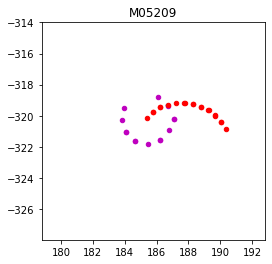

In [40]:
pos = 'M05209'
fit_arcs(pos, moves, cals, new_cals, 0, diag=True, tol=30)
plot_fiber(pos)

In [19]:
new_cals[:20].show_in_notebook()

idx,pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
0,M00282,3.1009,3.0717,226.0989,23.3064,299.9881,109.9557,0.0018,0.0019,0.0023,0.0009,11,17,3,3,1.5845,150.2561,30.1355,10.0621,14.9322,3.9040,179.5958
1,M00283,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,M00284,3.0448,3.0665,252.1800,32.3212,299.4526,109.8320,0.0031,0.0025,0.0033,0.0016,11,12,3,8,1.5788,150.0596,30.2919,9.9754,14.7317,17.2819,180.3301
3,M00296,3.0953,3.0820,194.8486,23.2853,299.9681,109.9102,0.0018,0.0022,0.0027,0.0009,11,14,3,6,1.6093,149.8001,30.2056,9.9910,14.8109,16.0322,178.9353
4,M00325,3.1836,3.0603,121.8945,23.3109,300.3828,109.0008,0.0019,0.0015,0.0021,0.0010,11,12,3,8,1.6167,150.0706,30.2403,9.9537,14.9139,17.2482,179.8223
5,M00411,3.1482,3.0446,347.1603,194.9594,299.7641,109.7974,0.0022,0.0017,0.0019,0.0011,11,19,3,1,1.5758,150.5783,30.1940,9.9954,14.8539,2.2154,179.8426
6,M00436,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,M00469,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,M00470,3.0251,3.0612,352.3817,185.9022,299.7880,109.2862,0.0020,0.0021,0.0028,0.0010,11,12,3,8,1.5477,150.5453,30.1530,9.9439,14.8890,17.1089,180.7179
9,M00636,2.9893,3.0514,299.1645,41.3363,299.7944,109.6920,0.0022,0.0031,0.0041,0.0011,11,12,3,8,1.5616,150.0590,30.2854,10.0040,14.8038,17.1245,179.9072


In [20]:
arc = new_cals['arc_t']
print(len(arc))

5020


In [21]:
tried = (cals['device_classified_nonfunctional']==False)
print(f"{np.sum(tried):4d} were tried")
print(f"{np.sum(tried&(arc<-7.5)):4d} didn't move")
print(f"{np.sum(tried&(arc<-4.5)&(arc>-7.5)):4d} rejected too many points")
print(f"{np.sum(tried&(arc<-0.5)&(arc>-4.5)):4d} failed to fit an arc")
print(f"{np.sum(tried&(arc>-0.5)&(arc<60)):4d} have too short an arc")

4240 were tried
  12 didn't move
   0 rejected too many points
   0 failed to fit an arc
   0 have too short an arc


In [22]:
#new_cals[tried&(arc<-7.5)]

In [23]:
sel = tried&(new_cals['arc_t']<-7.5)&(new_cals['arc_p']<-7.5)
print(" ".join(new_cals['pos_id'][sel]))
new_cals[sel]

M00283 M03125 M03360 M03506 M03827 M04056 M05036 M05143 M05310 M05473 M06585 M06906


pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M00283,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M03125,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M03360,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M03506,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M03827,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M04056,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M05036,0.0000,0.0000,0.0000,0.0000,-8.0000,-9.0000,0.0000,0.0000,9.9900,0.0000,1,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M05143,0.0000,0.0000,0.0000,0.0000,-9.0000,-9.0000,0.0000,0.0000,0.0000,0.0000,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
M05310,0.0000,0.0000,0.0000,0.0000,-8.0000,-9.0000,0.0000,0.0000,9.9900,0.0000,1,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [24]:
new_cals[tried&(new_cals['arc_t']>-7.5)&(new_cals['arc_p']<-7.5)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [25]:
new_cals[tried&(new_cals['arc_t']<-7.5)&(new_cals['arc_p']>-7.5)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [26]:
new_cals[tried&(new_cals['arc_p']>-7.5)&(new_cals['arc_p']<75)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M02281,3.0380,3.0789,132.3607,5.2356,298.9993,69.9035,0.0045,0.0012,0.0044,0.0021,12,10,2,10,3.1174,118.7254,30.1846,10.0104,13.0141,19.3382,170.8831
M02907,3.0648,3.0433,116.7222,32.3187,300.3365,70.1545,0.0022,0.0015,0.0051,0.0011,11,14,3,6,1.6054,149.5272,30.1249,10.0092,14.8435,0.1511,180.0498
M03929,2.7997,3.1196,362.4241,113.5468,299.9535,34.8567,0.0032,0.0015,0.0185,0.0016,11,17,3,3,1.6664,147.8738,30.2747,3.7620,14.7582,2.1080,159.9587
M05209,0.0000,0.0000,362.2490,77.4147,270.0091,-2.0000,0.0036,0.0000,9.9900,0.0022,9,10,4,8,1.5791,0.0000,59.3150,0.0000,14.6316,0.0000,0.0000
M06855,3.0141,3.0806,122.0162,5.2325,299.7376,69.8016,0.0015,0.0013,0.0043,0.0008,11,14,3,3,1.5718,150.1354,30.1079,9.9692,14.7552,0.1806,180.1080


In [37]:
new_cals[tried&(new_cals['arc_t']>-7.5)&(new_cals['arc_t']<260)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M00703,2.8362,3.0768,85.3871,50.4355,255.8340,110.5447,0.0028,0.0015,0.0015,0.0015,12,19,2,1,2.8994,121.4421,29.7263,10.0261,13.2536,2.9453,173.5207
M01377,3.1763,3.0322,142.7321,5.2339,149.6438,110.5617,0.0037,0.0015,0.0020,0.0055,6,12,2,8,4.2933,92.5337,59.7903,10.0608,0.2285,17.3546,146.4222
M02055,2.9605,3.0878,173.9227,113.7859,185.9264,110.6459,0.0024,0.0014,0.0017,0.0016,14,14,0,6,2.6875,127.2883,24.7659,10.0260,11.1774,7.3305,180.4478
M06714,3.0465,3.0446,262.6281,122.6976,197.3488,110.0510,0.0021,0.0014,0.0019,0.0013,14,12,0,8,1.5801,149.9305,15.9801,10.0298,6.8333,17.2690,179.5510


In [28]:
new_cals[tried&(new_cals['arc_t']>0)&(new_cals['median_angstep_t']<26)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M02055,2.9605,3.0878,173.9227,113.7859,185.9264,110.6459,0.0024,0.0014,0.0017,0.0016,14,14,0,6,2.6875,127.2883,24.7659,10.0260,11.1774,7.3305,180.4478
M06714,3.0465,3.0446,262.6281,122.6976,197.3488,110.0510,0.0021,0.0014,0.0019,0.0013,14,12,0,8,1.5801,149.9305,15.9801,10.0298,6.8333,17.2690,179.5510


In [29]:
new_cals[tried&(new_cals['arc_p']>0)&(new_cals['median_angstep_p']<8)]

pos_id,length_r1,length_r2,offset_x,offset_y,arc_t,arc_p,rms_t,rms_p,err.length_r2,err.offset_xy,nfit_t,nfit_p,nprune_t,nprune_p,theta_arc_radius,theta_arc_phi,median_angstep_t,median_angstep_p,rms_angstep_t,rms_angstep_p,max_p
str6,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
M03929,2.7997,3.1196,362.4241,113.5468,299.9535,34.8567,0.0032,0.0015,0.0185,0.0016,11,17,3,3,1.6664,147.8738,30.2747,3.7620,14.7582,2.1080,159.9587


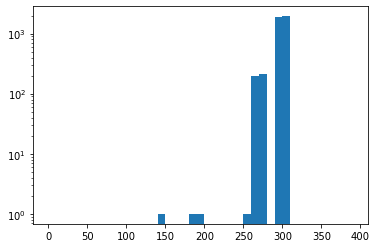

In [30]:
plt.hist(arc[tried&(arc>0)],range=[0,390],bins=39)
plt.semilogy()
plt.show()

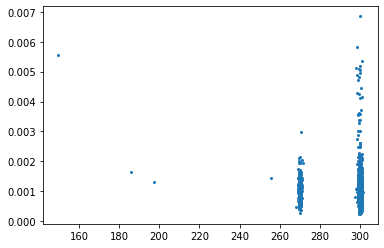

0.0009598081


In [31]:
sel = (arc>50)
plt.scatter(arc[sel], new_cals['err.offset_xy'][sel], s=4)
plt.show()
print(np.median(new_cals['err.offset_xy'][sel]))

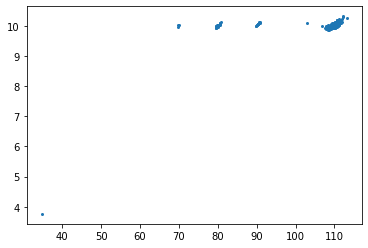

In [32]:
sel = (new_cals['arc_p']>0)
plt.scatter(new_cals['arc_p'][sel], new_cals['median_angstep_p'][sel],s=4)
plt.show()

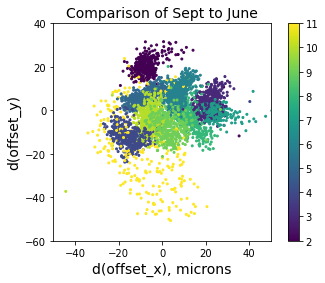

In [33]:
dx = (new_cals['offset_x']-cals['offset_x'])*1000
dy = (new_cals['offset_y']-cals['offset_y'])*1000
sel = (new_cals['arc_t']>0)
plt.scatter(dx[sel], dy[sel], s=4, c=present_cals['petal_id'][sel])
plt.colorbar()
plt.gca().set_aspect('equal')
plt.xlim([-50,50])
plt.ylim([-60,40])
plt.xlabel("d(offset_x), microns",size=14)
plt.ylabel("d(offset_y)",size=14)
plt.title("Comparison of Sept to June", size=14)
plt.show()

11.150790532972033 9.570723594597963


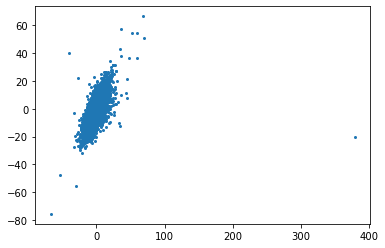

In [34]:
dr1 = (new_cals['length_r1']-cals['length_r1'])*1000
dr2 = (new_cals['length_r2']-cals['length_r2'])*1000
sel = (new_cals['arc_t']>0)&(new_cals['arc_p']>0)
print(np.std(dr1[sel]), np.std(dr2[sel]))
plt.scatter(dr1[sel], dr2[sel], s=4)
plt.show()

Plotting 68 fibers


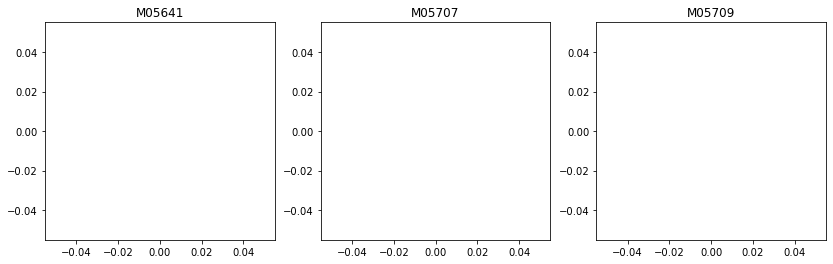

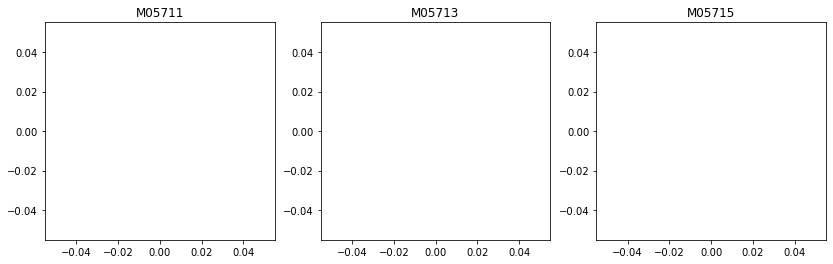

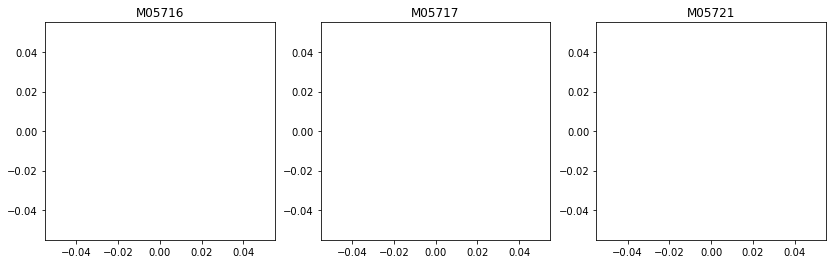

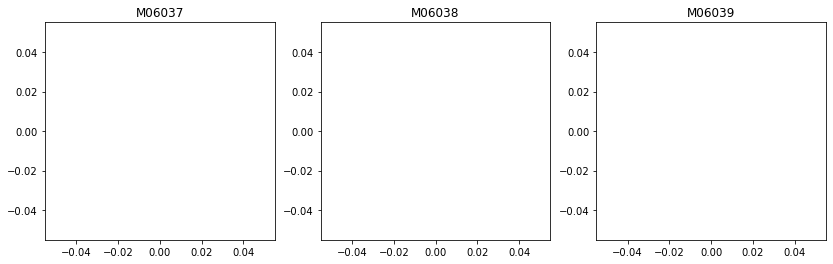

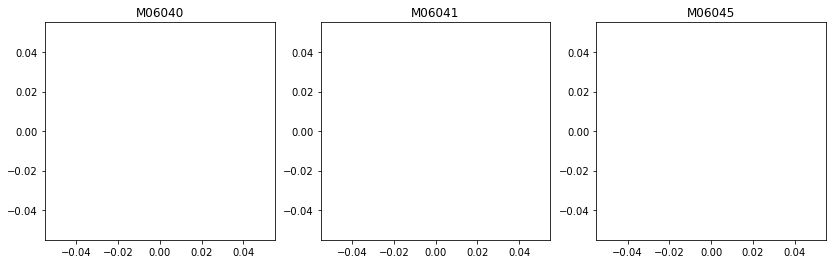

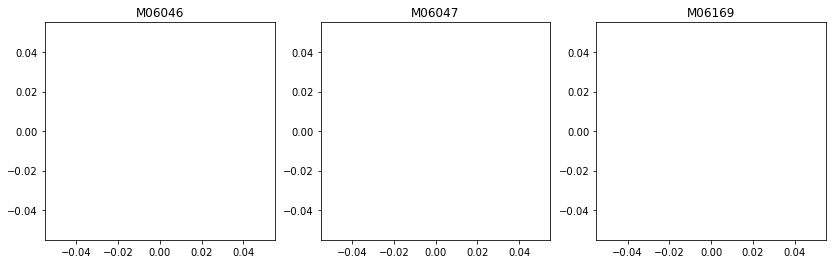

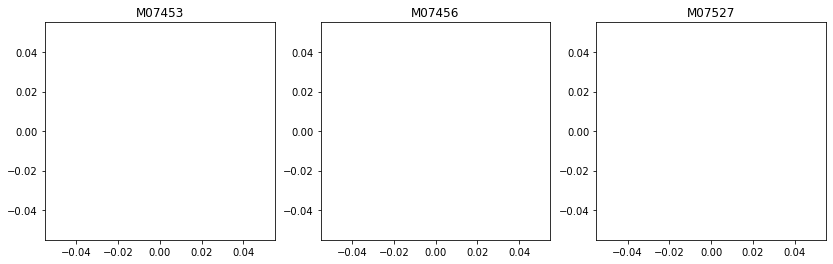

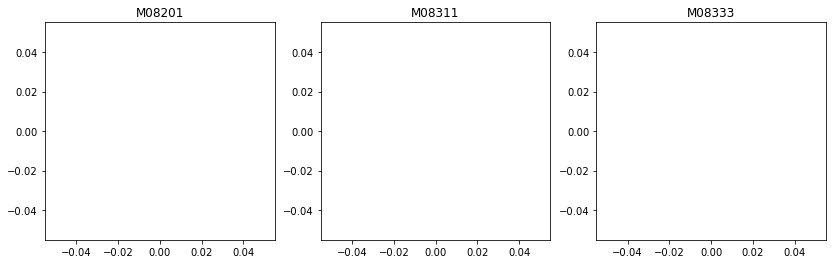

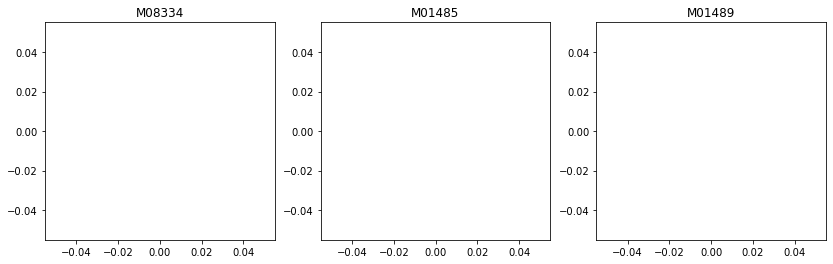

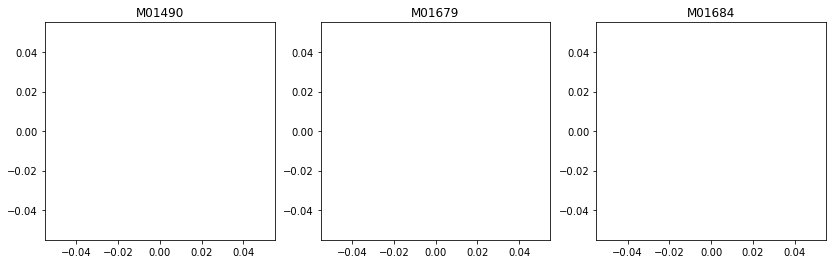

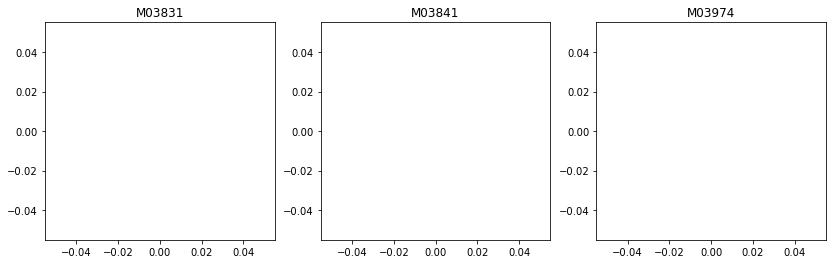

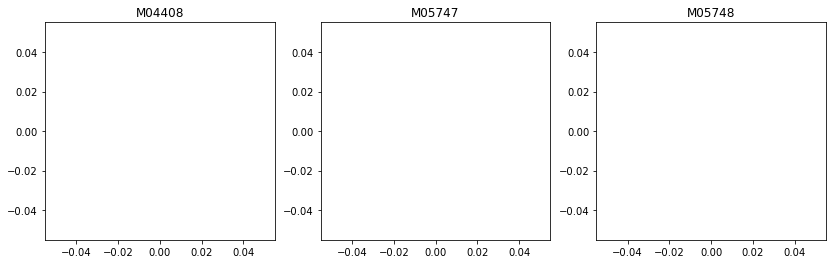

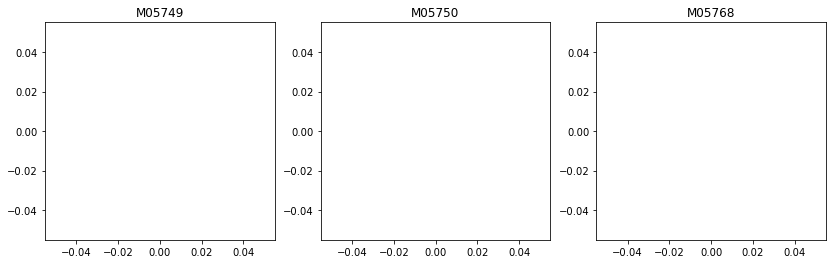

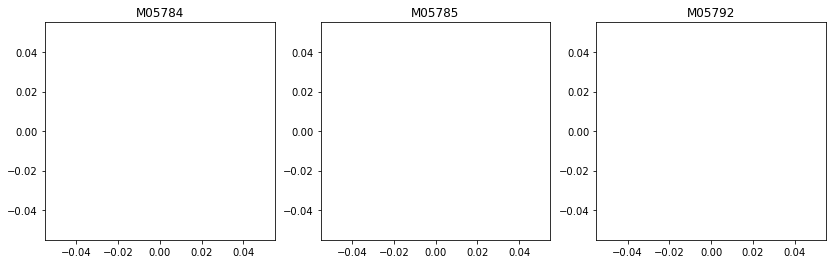

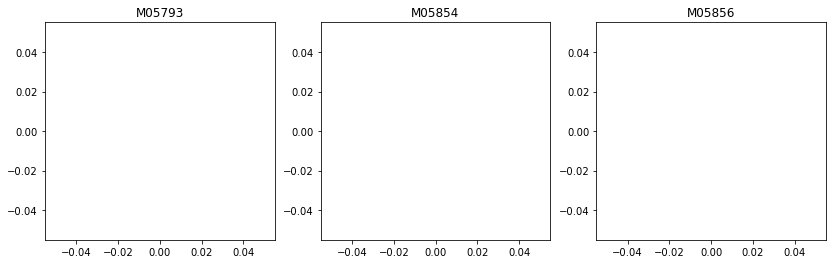

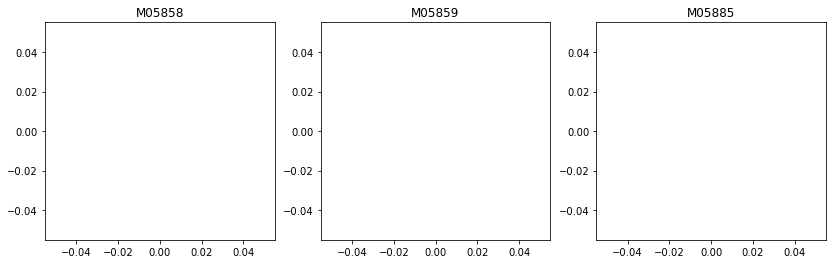

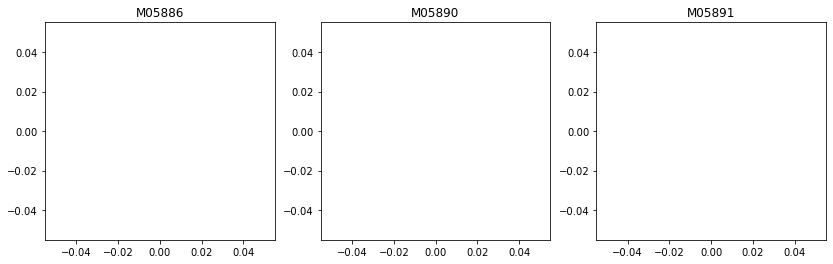

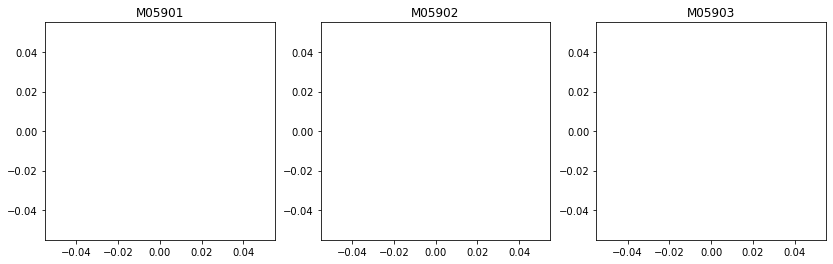

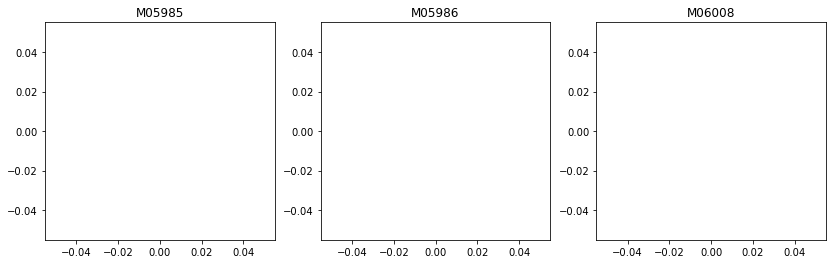

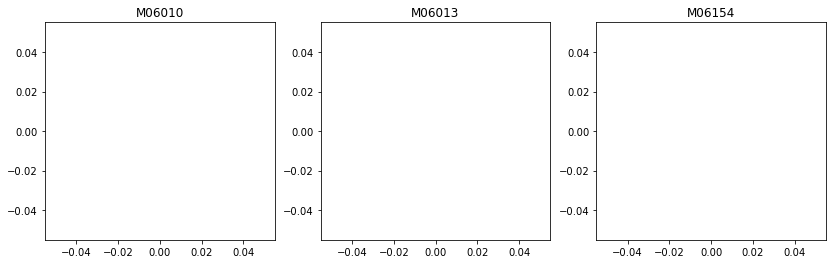

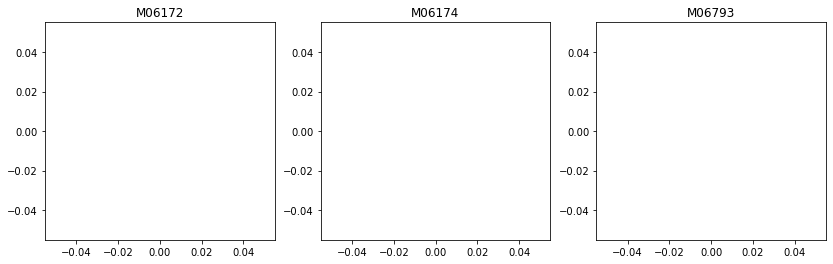

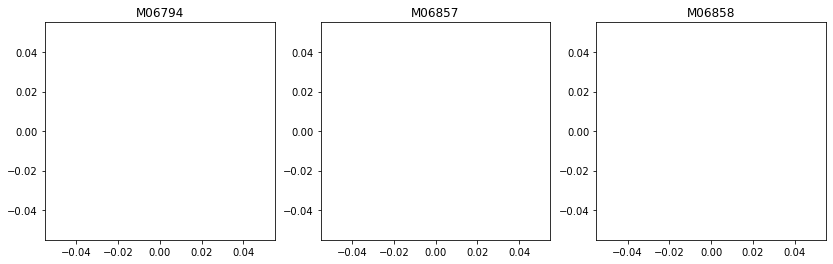

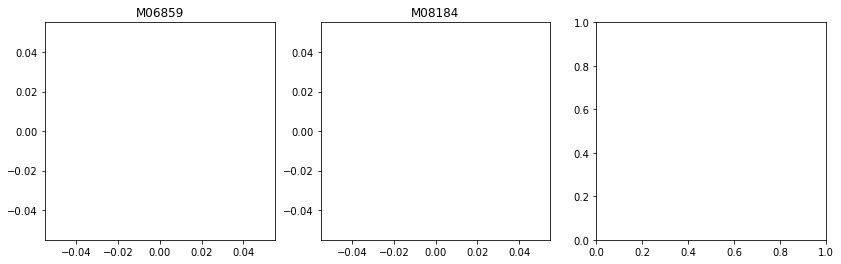

In [35]:
pet6 = ['M05641', 'M05707', 'M05709', 'M05711', 'M05713', 'M05715', 'M05716', 'M05717', 'M05721', 'M06037', 'M06038', 'M06039', 'M06040', 'M06041', 'M06045', 'M06046', 'M06047', 'M06169', 'M07453', 'M07456', 'M07527', 'M08201', 'M08311', 'M08333', 'M08334', 'M01485', 'M01489', 'M01490', 'M01679', 'M01684', 'M03831', 'M03841', 'M03974', 'M04408', 'M05747', 'M05748', 'M05749', 'M05750', 'M05768', 'M05784', 'M05785', 'M05792', 'M05793', 'M05854', 'M05856', 'M05858', 'M05859', 'M05885', 'M05886', 'M05890', 'M05891', 'M05901', 'M05902', 'M05903', 'M05985', 'M05986', 'M06008', 'M06010', 'M06013', 'M06154', 'M06172', 'M06174', 'M06793', 'M06794', 'M06857', 'M06858', 'M06859', 'M08184']
tpet6 = Table([pet6])
tpet6.rename_column('col0','pos_id')
plot_many_fibers(tpet6)

Plotting 15 fibers


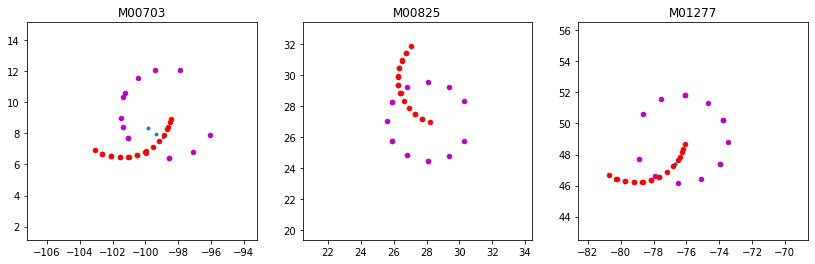

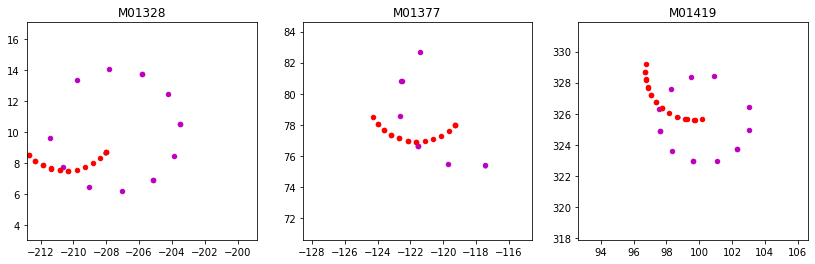

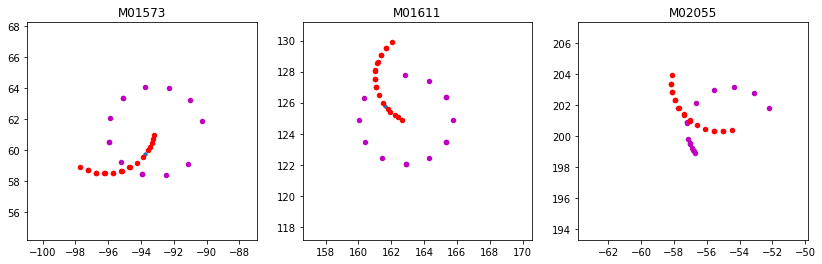

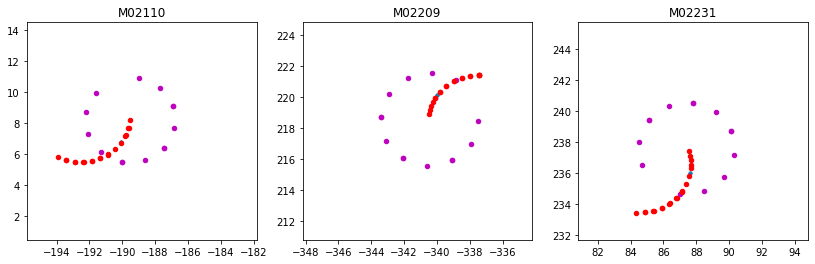

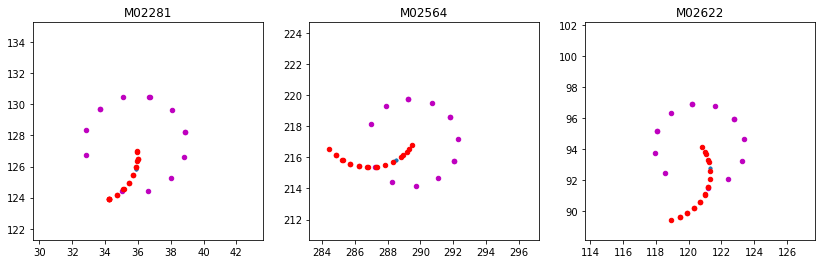

In [36]:
new15 = ['M00703', 'M00825', 'M01277', 'M01328', 'M01377',
'M01419', 'M01573', 'M01611', 'M02055',
'M02110', 'M02209', 'M02231', 'M02281', 'M02564', 'M02622']
tnew15= Table([new15])
tnew15.rename_column('col0','pos_id')
plot_many_fibers(tnew15)